In [9]:
import pandas as pd
import numpy as np
import shap
import json
import pickle
import optuna
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, multilabel_confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [ ]:
# load dataset
df = pd.read_csv('../../../../datasets/atis_dataset_preprocessed.csv', sep=';')

In [11]:
# define label columns
label_columns = ['ILS', 'RNAV', 'RNP', 'VISUAL']

# define features and targets
X = df.drop(columns=label_columns)

# one-hot encode features that are categorical
X = pd.get_dummies(X, columns=['airport_icao', 'runway_designator_side', 'weather_phenomenon', 
                                'runway_designator_number', 'rvr_tendency', 'runway_ils_category'])

In [12]:
y = df[label_columns]

In [13]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

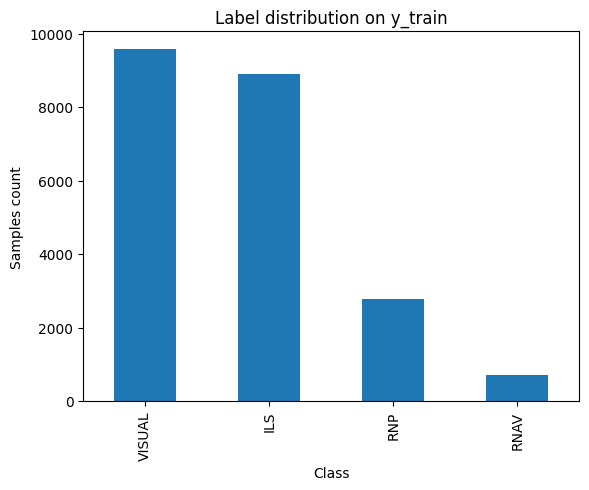

Label distribution:
 VISUAL    9576
ILS       8904
RNP       2782
RNAV       698
dtype: int64


In [14]:
# check for label distribution
label_counts = y_train.sum().sort_values(ascending=False)
label_counts.plot(kind='bar')
plt.title('Label distribution on y_train')
plt.xlabel('Class')
plt.ylabel('Samples count')
plt.show()

print("Label distribution:\n", label_counts)

In [15]:
# oversampling imbalanced labels
try:
    X_train_sm, y_train_sm = SMOTE(random_state=42).fit_resample(X_train, y_train)
    print("SMOTE successful. X_train after SMOTE:", X_train_sm.shape)
    print("Label distribution after SMOTE:\n", pd.DataFrame(y_train_sm, columns=label_columns).sum())
    X_train_use, y_train_use = X_train_sm, y_train_sm
except Exception as e:
    print("SMOTE failed for multi-label")
    X_train_use, y_train_use = X_train, y_train

SMOTE failed for multi-label


In [16]:
# build and train multi-label model + hyperparameter tuning
def objective(trial):
    # Each hyperparameter is sampled by Optuna using Bayesian optimization
    n_estimators = trial.suggest_int('n_estimators', 100, 300)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 10)
    subsample = trial.suggest_float('subsample', 0.7, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.7, 1.0)
    gamma = trial.suggest_float('gamma', 0, 5)
    reg_alpha = trial.suggest_float('reg_alpha', 0, 1)
    reg_lambda = trial.suggest_float('reg_lambda', 0, 1)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 5)

    model = OneVsRestClassifier(XGBClassifier(
        eval_metric='logloss',
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        min_child_weight=min_child_weight,
    ))

    model.fit(X_train_use, y_train_use)
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    return f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=256)

[I 2025-05-18 11:31:39,095] A new study created in memory with name: no-name-95fb964a-6358-403a-b6cb-4a202328c98e
[I 2025-05-18 11:31:41,035] Trial 0 finished with value: 0.8700604260433091 and parameters: {'n_estimators': 252, 'learning_rate': 0.17121332874209044, 'max_depth': 3, 'subsample': 0.9929226632608266, 'colsample_bytree': 0.7165403688354319, 'gamma': 3.0343971951577626, 'reg_alpha': 0.0672154409716772, 'reg_lambda': 0.5276353407470417, 'min_child_weight': 1}. Best is trial 0 with value: 0.8700604260433091.
[I 2025-05-18 11:31:42,932] Trial 1 finished with value: 0.8913131155063452 and parameters: {'n_estimators': 151, 'learning_rate': 0.11394961308972748, 'max_depth': 10, 'subsample': 0.819290435532228, 'colsample_bytree': 0.9540639355947124, 'gamma': 2.9511520885777283, 'reg_alpha': 0.8858343315771842, 'reg_lambda': 0.5493107932753325, 'min_child_weight': 1}. Best is trial 1 with value: 0.8913131155063452.
[I 2025-05-18 11:31:44,582] Trial 2 finished with value: 0.873000282

In [17]:
# trials progress
print(f"Best params: {study.best_trial.params}")
print(f"Best macro F1: {study.best_value}")

Best params: {'n_estimators': 116, 'learning_rate': 0.2454489998694991, 'max_depth': 10, 'subsample': 0.868245018495419, 'colsample_bytree': 0.9795271581825494, 'gamma': 0.7383905425405373, 'reg_alpha': 0.707629995473688, 'reg_lambda': 0.3081218908764143, 'min_child_weight': 1}
Best macro F1: 0.9075949696659947


In [ ]:

# save all trials log
df = study.trials_dataframe()
df.to_csv("../../optuna_trials/xgb_with_airport_feats_optuna_trials.csv", index=False)

In [ ]:
# save trained best model
best_params = study.best_trial.params
best_model = OneVsRestClassifier(XGBClassifier(
    eval_metric='logloss',
    **best_params
))

best_model.fit(X_train_use, y_train_use)

with open("../../trained_models/model-xgb-ovr-BYS-with_airport_feats.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [ ]:
# features in order
feature_order = list(X.columns)

# save to json
with open("../../feature_order/feature_order_xgb_ovr_BYS_with_airport_feats.json", "w") as f:
    json.dump(feature_order, f)

In [21]:
# predict and evaluate
y_pred = best_model.predict(X_test)
empty_mask = y_pred.sum(axis=1) == 0
no_predictions = np.sum(empty_mask)
print(f"Samples with no predicted labels: {no_predictions} out of {len(y_pred)}")
print(X_test[empty_mask])
print(classification_report(y_test, y_pred, target_names=label_columns, zero_division=0))

Samples with no predicted labels: 23 out of 3819
       visibility  wind_speed  wind_gust  wind_direction     rvr  headwind  \
466          10.0           6          0             100  6000.0      -3.0   
115          10.0           8          0             170  6000.0       5.1   
4336         10.0          11          0             240  5500.0       8.4   
16384        10.0           4          0             120  6000.0      -0.7   
16285        10.0           9          0             200  6000.0       8.5   
10859        10.0           5          0             220  6000.0       3.2   
2136         10.0          19          0             250  6000.0      16.5   
15104        10.0           4          0             250  6000.0       3.5   
15536        10.0          23         31             190  6000.0      19.9   
127          10.0           4          0             200  6000.0       3.8   
7177         10.0           5          0             260  6000.0       3.8   
2677         10

C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


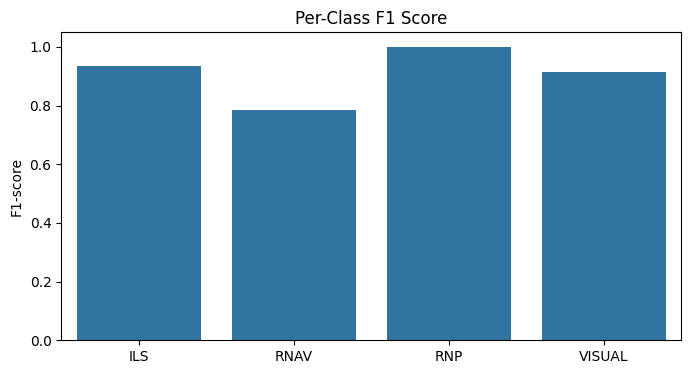

In [22]:
# per-class F1-score bar chart
report = classification_report(y_test, y_pred, output_dict=True)
f1_scores = [report[str(i)]['f1-score'] for i in range(len(label_columns))]
plt.figure(figsize=(8,4))
sns.barplot(x=label_columns, y=f1_scores)
plt.title("Per-Class F1 Score")
plt.ylabel("F1-score")
plt.show()

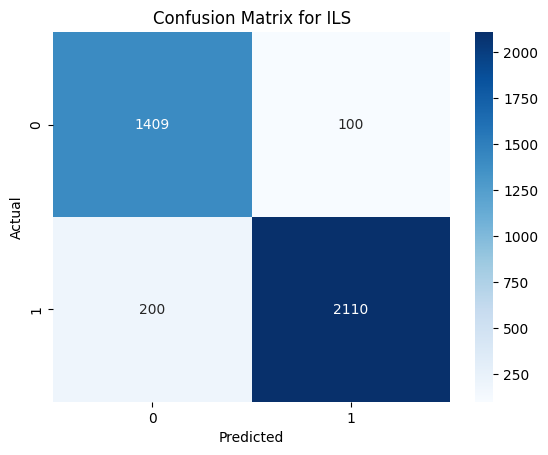

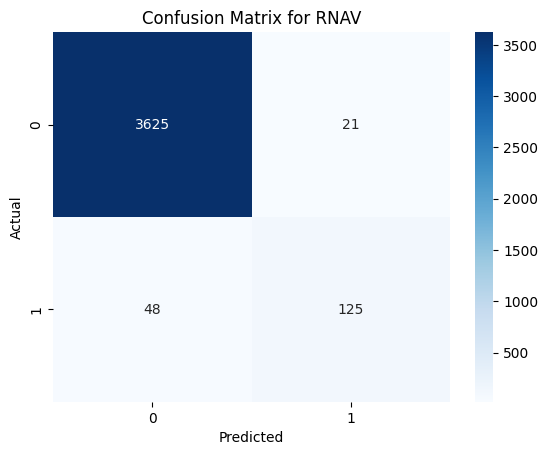

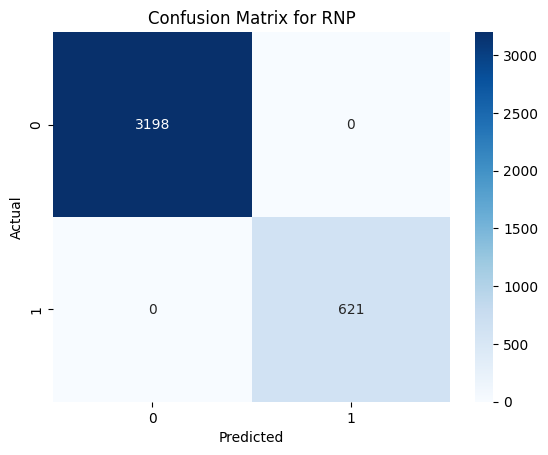

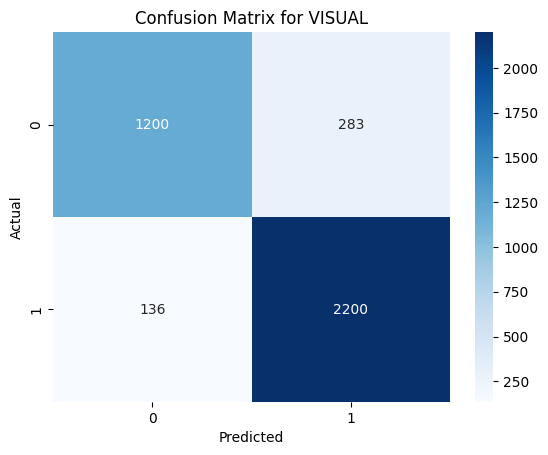

In [23]:
# confusion matrix per label
cm = multilabel_confusion_matrix(y_test, y_pred)
for i, label in enumerate(label_columns):
    plt.figure()
    sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

SHAP summary plot for ILS


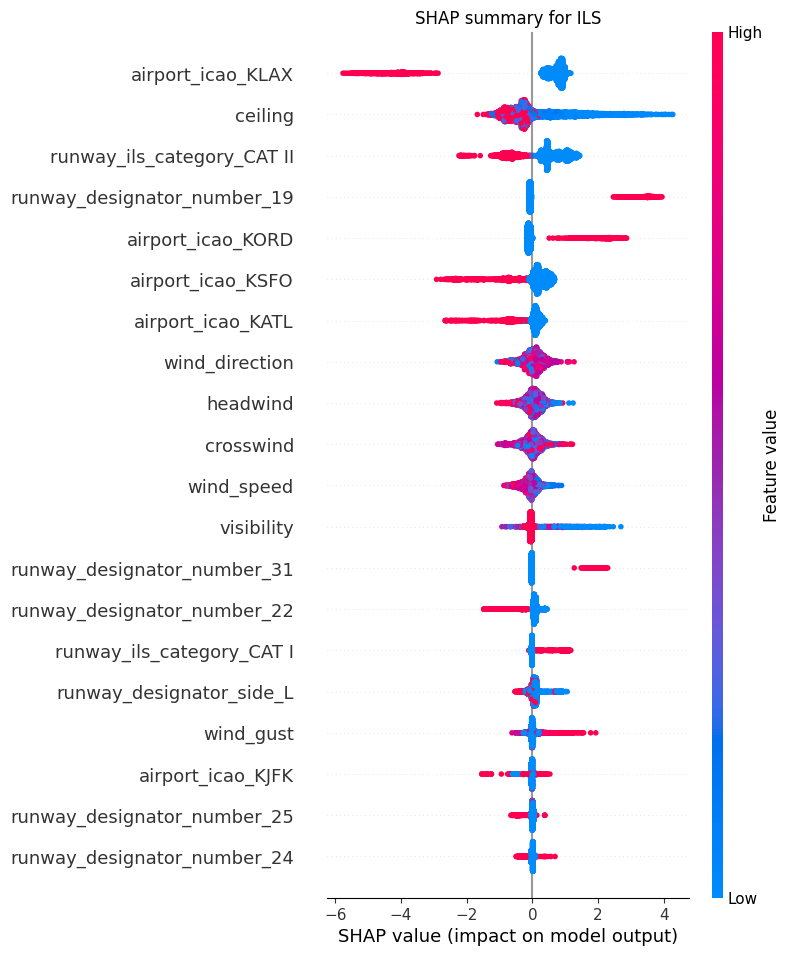

SHAP summary plot for RNAV


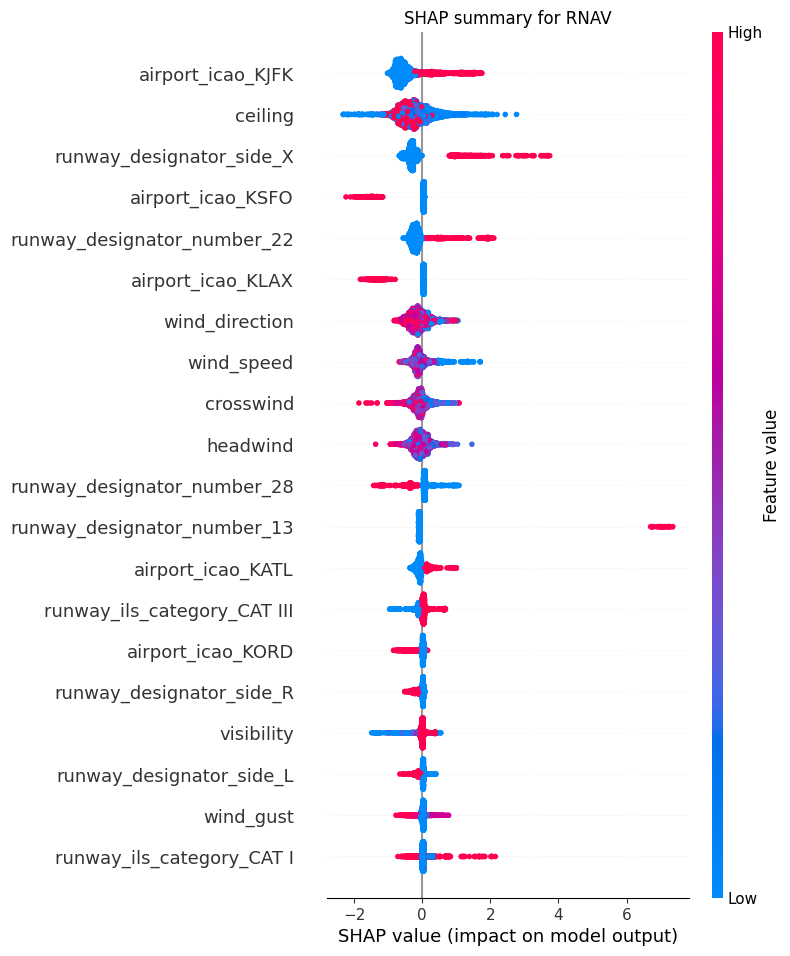

SHAP summary plot for RNP


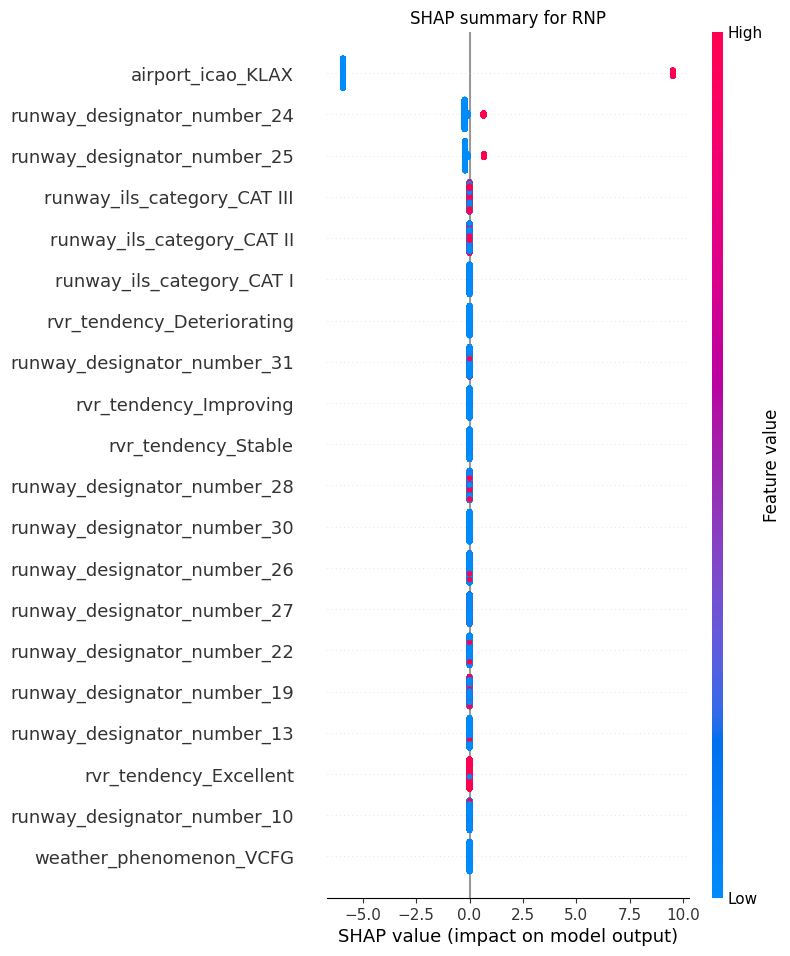

SHAP summary plot for VISUAL


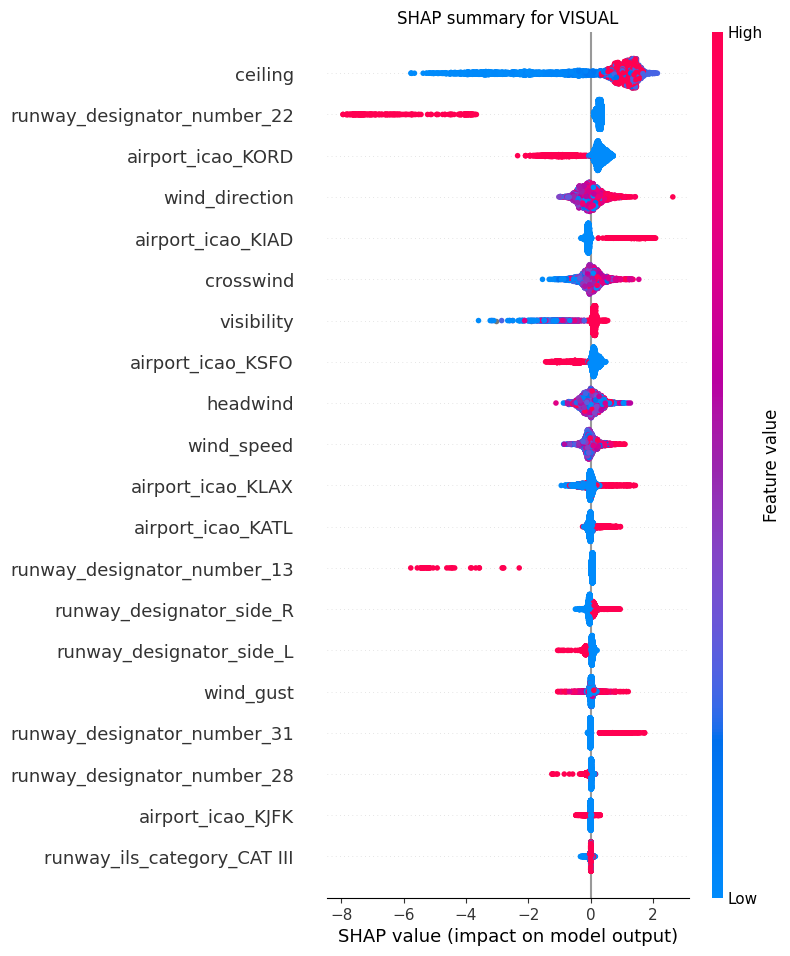

In [24]:
# SHAP summary plot per label
for idx, label in enumerate(label_columns):
    print(f"SHAP summary plot for {label}")
    explainer = shap.TreeExplainer(best_model.estimators_[idx])
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title(f"SHAP summary for {label}")
    plt.show()

In [25]:
# false predictions cases
for i, label in enumerate(label_columns):
    false_positives = np.where((y_test[label].values == 0) & (y_pred[:, i] == 1))[0]
    false_negatives = np.where((y_test[label].values == 1) & (y_pred[:, i] == 0))[0]
    print(f"\n{label} False Positives (max 5):")
    display(X_test.iloc[false_positives[:5]])
    print(f"{label} False Negatives (max 5):")
    display(X_test.iloc[false_negatives[:5]])


ILS False Positives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_28,runway_designator_number_30,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III
18371,10.0,18,0,250,6000.0,15.6,-9.0,1300,False,False,...,True,False,False,False,True,False,False,False,True,False
17282,10.0,5,0,190,6000.0,-0.0,-5.0,20000,True,False,...,True,False,False,False,True,False,False,False,True,False
18995,10.0,8,0,260,6000.0,8.0,0.0,20000,True,False,...,False,False,False,False,True,False,False,False,True,False
5155,10.0,9,0,280,6000.0,6.9,5.8,99999,False,False,...,False,False,False,False,True,False,False,False,False,True
17495,10.0,7,0,210,6000.0,6.9,-1.2,9500,False,False,...,False,False,False,False,True,False,False,False,False,True


ILS False Negatives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_28,runway_designator_number_30,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III
5922,10.0,10,0,260,6000.0,9.4,-3.4,20000,False,False,...,True,False,False,False,True,False,False,False,True,False
15734,10.0,3,0,-1,6000.0,-0.5,3.0,6500,True,False,...,False,False,False,False,True,False,False,False,True,False
9149,10.0,4,0,60,6000.0,-3.1,2.6,99999,False,False,...,True,False,False,False,True,False,False,False,True,False
13485,10.0,6,0,220,6000.0,3.0,-5.2,99999,True,False,...,True,False,False,False,True,False,False,False,True,False
115,10.0,8,0,170,6000.0,5.1,-6.1,23000,False,False,...,False,False,False,False,True,False,False,False,False,True



RNAV False Positives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_28,runway_designator_number_30,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III
16049,10.0,7,0,120,6000.0,-1.2,-6.9,1600,False,False,...,False,False,False,False,True,False,False,False,False,True
12911,10.0,8,0,210,6000.0,7.9,-1.4,20000,False,False,...,False,False,False,False,True,False,False,False,False,True
16274,10.0,15,0,180,6000.0,11.5,-9.6,99999,False,False,...,False,False,False,False,True,False,False,False,False,True
15407,10.0,5,0,200,6000.0,4.7,-1.7,25000,False,False,...,False,False,False,False,True,False,False,False,False,True
8495,10.0,19,27,210,6000.0,18.7,-3.3,23000,False,False,...,False,False,False,False,True,False,False,False,False,True


RNAV False Negatives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_28,runway_designator_number_30,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III
14378,7.0,6,0,140,6000.0,4.6,3.9,15000,True,False,...,False,False,False,False,True,False,False,False,False,True
466,10.0,6,0,100,6000.0,-3.0,-5.2,10000,False,False,...,False,False,False,False,True,False,False,False,False,True
11729,10.0,12,0,200,6000.0,11.3,-4.1,8500,False,False,...,False,False,False,False,True,False,False,False,False,True
8242,10.0,11,0,160,6000.0,5.5,9.5,7000,True,False,...,False,False,False,False,True,False,False,False,False,True
17495,10.0,7,0,210,6000.0,6.9,-1.2,9500,False,False,...,False,False,False,False,True,False,False,False,False,True



RNP False Positives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_28,runway_designator_number_30,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III


RNP False Negatives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_28,runway_designator_number_30,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III



VISUAL False Positives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_28,runway_designator_number_30,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III
5922,10.0,10,0,260,6000.0,9.4,-3.4,20000,False,False,...,True,False,False,False,True,False,False,False,True,False
15734,10.0,3,0,-1,6000.0,-0.5,3.0,6500,True,False,...,False,False,False,False,True,False,False,False,True,False
4073,10.0,8,0,150,6000.0,5.1,6.1,99999,False,False,...,False,False,False,False,True,False,False,False,False,True
2129,10.0,9,18,280,6000.0,8.5,3.1,5500,True,False,...,False,False,False,False,True,False,False,False,True,False
14378,7.0,6,0,140,6000.0,4.6,3.9,15000,True,False,...,False,False,False,False,True,False,False,False,False,True


VISUAL False Negatives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,airport_icao_KATL,airport_icao_KIAD,...,runway_designator_number_28,runway_designator_number_30,runway_designator_number_31,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,runway_ils_category_CAT I,runway_ils_category_CAT II,runway_ils_category_CAT III
7726,10.0,5,0,190,6000.0,5.0,0.0,9000,False,True,...,False,False,False,False,True,False,False,False,False,True
13740,10.0,5,0,190,6000.0,0.9,-4.9,8000,True,False,...,False,False,False,False,True,False,False,False,True,False
18371,10.0,18,0,250,6000.0,15.6,-9.0,1300,False,False,...,True,False,False,False,True,False,False,False,True,False
3323,10.0,14,25,210,6000.0,4.8,-13.2,25000,False,False,...,True,False,False,False,True,False,False,False,False,True
5863,10.0,8,0,310,6000.0,6.9,4.0,99999,False,False,...,True,False,False,False,True,False,False,False,False,True
